# Learning Functional Level Design: Grover

This is a step-by-step example of how to use the Classiq Platform at the functional level. The goal is to show you the advantages of high-level quantum design. We will do so be designing a search algortihm - Grover/Amplitude Amplification (we assume basic familiarity with the theory of the Grover operaotr).

As the name suggests, this algorithm searches for the answers to a specific question. The question we are intrested here is:

**Given 2 non-negative integers a and b, smaller than 4, what pairs of (a,b) are summed up to 4 ? i.e. (a,b) for which a+b=4**

Of course the problem is very simple and the solutions are: *{(3,1),(2,2),(1,3)}*. But the main advantages of high-level quantum algortihm design are manifested even here! Some real world example for a search problems can be finding a specfic song in a data base from only listening to a few seconds (the SHAZAM App)


## The Final Circuit

Let's start from the final circuit we will receive and then go through the processes of building it! This way we will understand the algortihm in a better way.

So this is the full circuit:

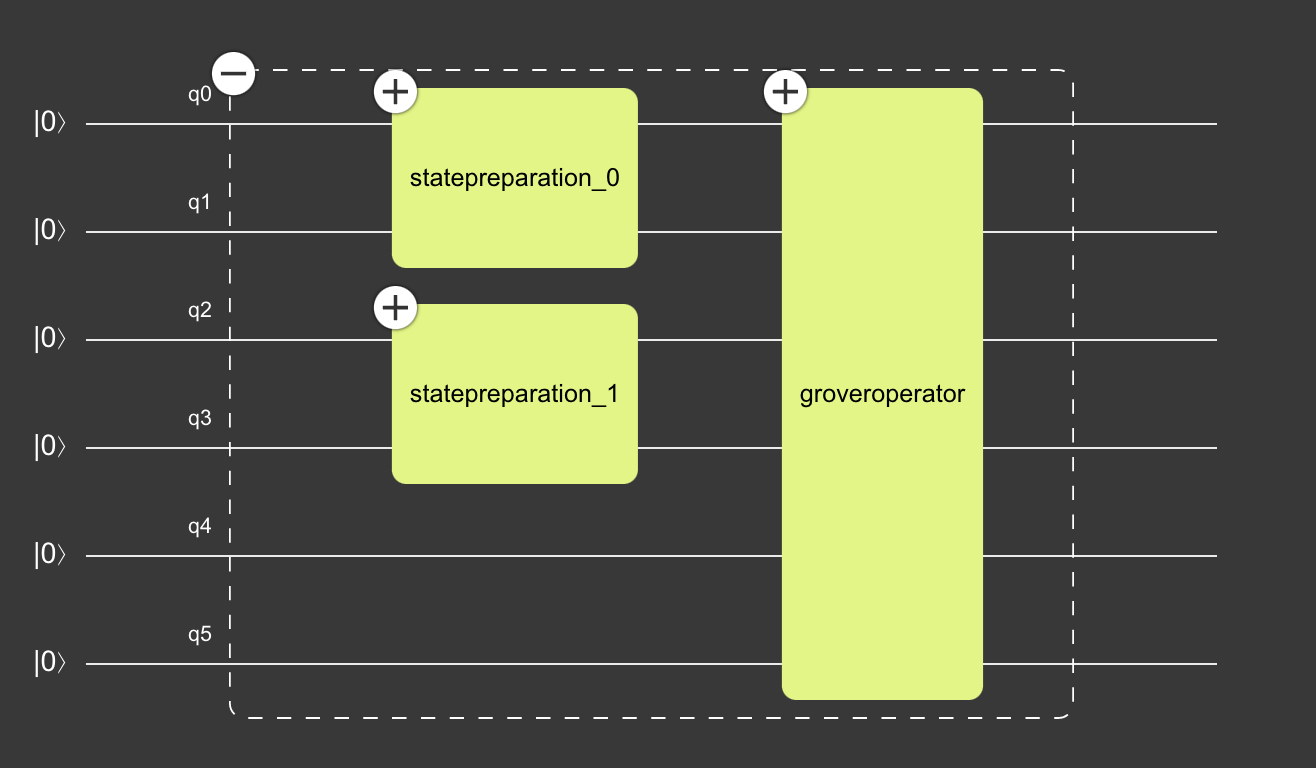

The circuit represents the algorithm, the functional model we design. In our example, we can see that it is composed from two types of functional blocks: state preperation and Grover operator.

The way we build models is by:

1. Defining the functional blocks

2. Defining an high-level functional model that will contain the functional blocks

3. Wiring the blocks within the high-level functional model

## 1. Defining the Functional Blocks

### State preperation

Let's start from the first two blocks of the state preperations we have on the right:

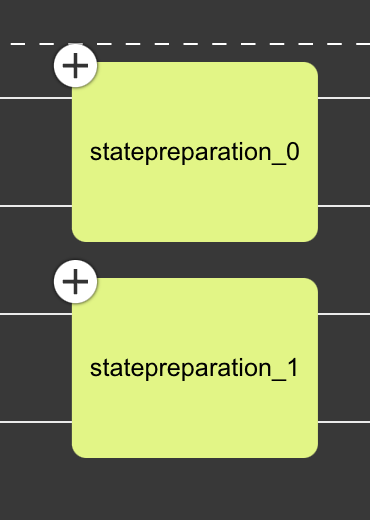

We want to have two state preparation objects, each of them acts on a different register of qubits. One register will represent the value of $a$ and one the value of $b$.

The way we define these objects is with the `StatePreparation` object. This object receives the desired probability distribution and an error metric for the implementaions (since we usually have the trade-off of accuracy vs. depth of implementation, so we want to hace the minimal implemenation that perform our desired state preperation up to a given error).

What are the probability distributions? Because we know $a,b$ can be in the range [0,3] with 4 different optional values (0,1,2,3), the registers representing their values must conatin 2 qubits. We know for sure that the neither $a=0$ nor $b=0$. Hence we can initiate the registers as uniformly distributed over the values $1,2,3$:

In [ ]:
prob_a = [0, 1 / 3, 1 / 3, 1 / 3]
prob_b = [0, 1 / 3, 1 / 3, 1 / 3]

And the state preparation object that will create this probability distribution:

In [ ]:
from classiq.builtin_functions import StatePreparation

sp_a = StatePreparation(probabilities=prob_a, error_metric={"KL": {"upper_bound": 0.1}})

sp_b = StatePreparation(probabilities=prob_b, error_metric={"KL": {"upper_bound": 0.1}})

Above we defined the error metric to be according to the Kullback-Leibler (KL) divergence metric, with the upper bound being 0.1.

### The Grover operator

The second functional block we have is the Grover operator, that repeats twice. The reason for the two repetitions is due to the number of solutions we expect (5).

Unlike the `StatePreparation` operator, the `GroverOperator` is composed from several functional blocks by themselves, where some of them we need to define. These are:

1. The `ArithmeticOracle`
2. `StatePreparation` over the register of $a$ and $b$
3. Diffuser
4. Another `StatePreparation` over the register of $a$ and $b$

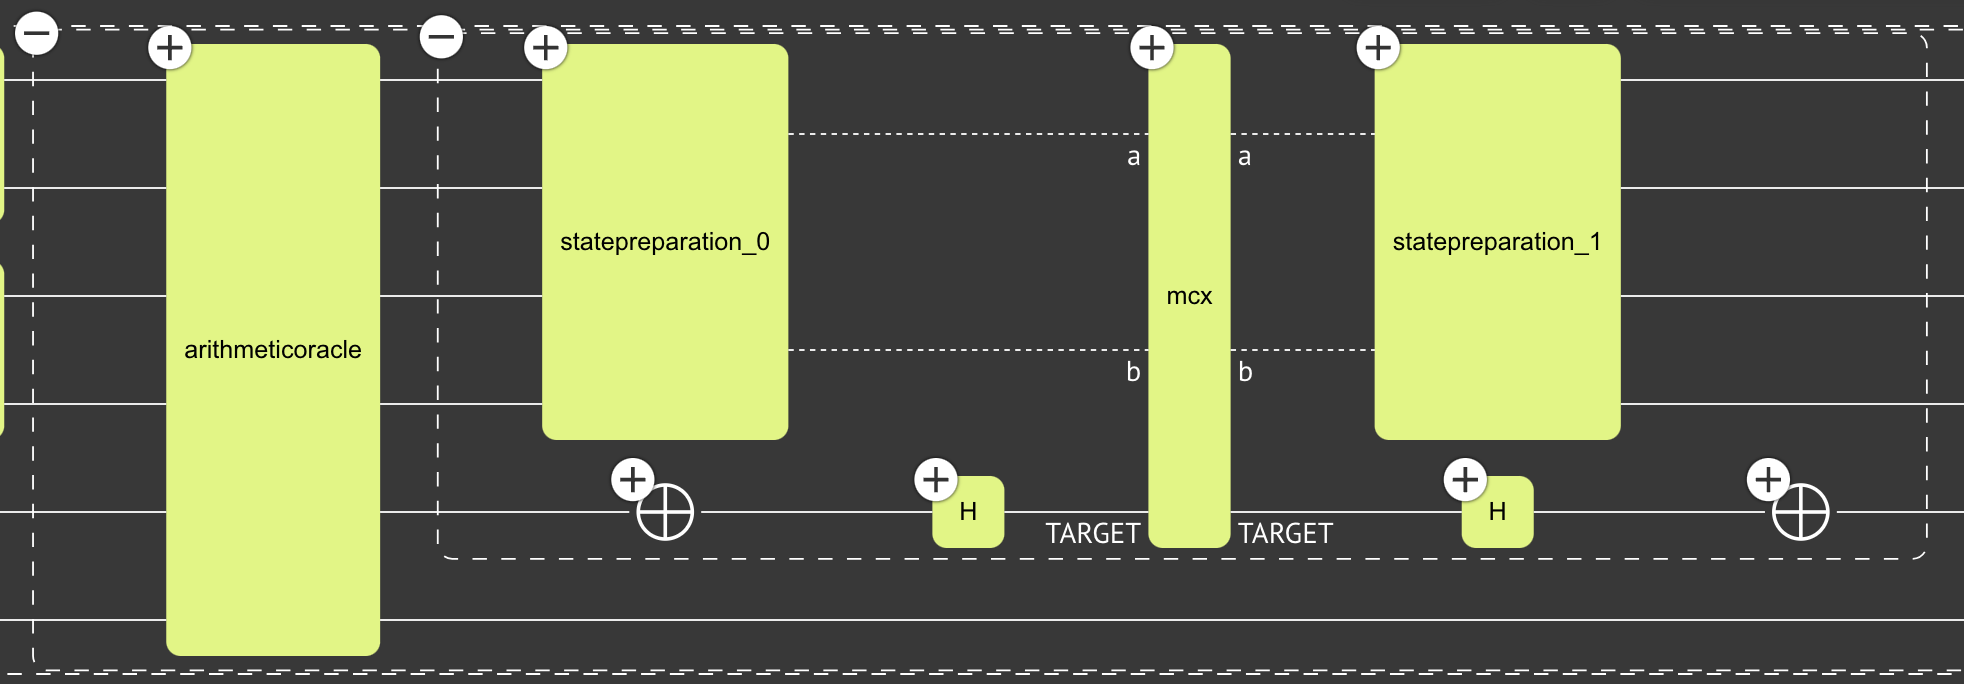

#### The Arithmetic Oracle

At the heart of the Grover operator lies the Arithmetic Oracle. This Oracle is a sub-quantum algorithm that marks states that are the desired solution in the following way:

$\ket{x}\rightarrow (-1)^{f(x)}\ket{x}$

where $f(x)=1$ if $x$ is a solution and $f(x)=0$ otherwise. One should treat $x$ as $x=(a,b)$, such that a solution $f(x)=f((a,b))=1$ if and only if $a+b=4$.

There are multiple ways of implementing a desired oracle, and the implementaion depends on many parmeters such as the number of auxilary qubits, and might be complicates. This is the reason it is usually referred as a 'black box'!

But someone needs to implements this black box according to your availble resources and needs, and this is exactly one of the things the Classiq Platform does for you!  It optimizes an implementaion of an Oracle specifically designed for your needs, and all you need to do is to just define them..

When defining the Oracle, we need to define two things: the expression we are searching for, and how the values are incorporated into the search - via quantum registers.

In addition, we want to tell the Classiq Platform that we want to optimize the uncomputation. That is, the implementaion of the oracle includes some auxillary qubits that our "value registers" are getting entangles to during the algorithm. We need to un-entangle them in order to not ruin the calculation - this is the uncomputation.

In [ ]:
from classiq import RegisterUserInput
from classiq.builtin_functions import ArithmeticOracle

# How many qubits are per register of a and b?
num_of_qubits = 2

# Defining the oracle
oracle = ArithmeticOracle(
    expression="a+b==4",
    definitions={
        "a": RegisterUserInput(size=num_of_qubits),
        "b": RegisterUserInput(size=num_of_qubits),
    },
    uncomputation_method="optimized",
)

The oracle is a Python object that will be incorporated into our high-level functional model later on.

#### The State Preparation

Above we have defined state preperations, but they were applied on the two registers of $a$ and $b$ seperately. We want to apply one general state preperation for the general Grover operator that encompasses the two registers we have.

Therefore, we will use the Kronecker product (outer product): $p_{ab}=p_a \otimes p_b$, defined by the Numpy package, and then build another `StatePreparation` object:

In [ ]:
import numpy as np

prob_ab = np.kron(prob_b, prob_a)
sp_ab = StatePreparation(
    probabilities=prob_ab, error_metric={"KL": {"upper_bound": 0.1}}
)

#### The Diffuser

In the above implementaiton, the diffuser is a general one:

$2\ket{0}\bra{0}-\mathbb{I}$.

Therefore, there is no need to define it in particular.

#### The complete Grover Operator

Having all the building blocks of the `GroverOperator`, the `grover` object can be defined now:

In [ ]:
from classiq.builtin_functions import GroverOperator

grover = GroverOperator(oracle_params=oracle, state_preparation_params=sp_ab)

How many times the Grover operator will be repeated? This is defined according to the following equation:

$[\frac{\pi}{4}\sqrt{\frac{N}{M}}]$,

where $N$ is the number of possible values the two registers can collectively have ($3^2$), and $M$ is the number of solutions (3).

Therefore, in our case

In [ ]:
total_num_of_qubits = 2 * num_of_qubits
N = 3**2
M = 3
num_of_iterations = int(np.round(np.pi / 4 * np.sqrt(N / M)))
print("#iterations =", num_of_iterations)

## 2. Defining the High-Level Functional Model

The high-level functional model encapsulates all the functionalities of our algorithm, and specifically all the building blocks we have defined. The model is stored within an instance of the `Model` object:

In [ ]:
from classiq import Model

model = Model()

In this tutorial we simply want to take samples on all the qubits from the resulting circuit.

In [ ]:
model.sample()

## 3. Wiring the Blocks within the High-Level Functional Model

Now that we have all the building blocks for our model, we need to wire them up. Let's have another look on the final circuit to guide us:

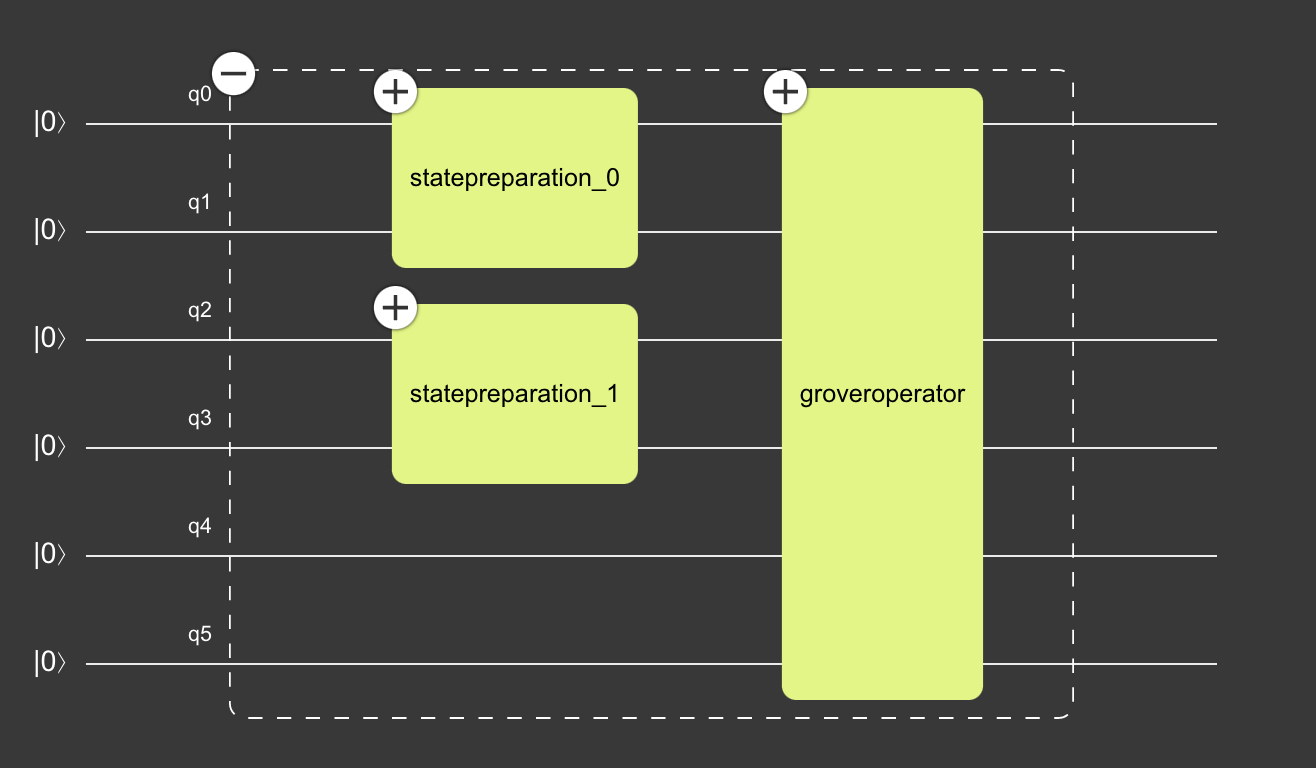

First we wire the state preperations with the `StatePreparation`s objects we have defined `sp_a` and `sp_b`:

In [ ]:
a = model.StatePreparation(params=sp_a)
b = model.StatePreparation(params=sp_b)

print(a)
print(b)

The outputs of the above wirings are two dictionaries that are necessary for the correct wiring. Now we would like to wire the Grover operators. The first one acts on the registers were the state preperation were defined:

In [ ]:
grover_dict = model.GroverOperator(
    params=grover, in_wires={"a": a["OUT"], "b": b["OUT"]}
)

**IF** we would have other Grover operators, they would have been wired in the following way:

In [ ]:
for i in range(num_of_iterations - 1):
    grover_dict = model.GroverOperator(
        params=grover,
        in_wires={"a": grover_dict["a"], "b": grover_dict["b"]},
    )

The last piece of wiring left to do is to define the relevant outputs for the model:

In [ ]:
model.set_outputs({"a": grover_dict["a"], "b": grover_dict["b"]})

And that's it! Our model is ready :)

## Synthesizing A Circuit

Now with this high-level functional model, the Classiq Platform can create a quantum circuit that implements it according to the constraints and optimizations parameters we want to define.

In this example, we would like to limit the circuit for 12 qubits, but to optimize on the width of the circuit. i.e. to use as fewer qubits possible. That is to ask the Classiq Platform to come up with the shortest implementation possible among all possible implementations!

In [ ]:
from classiq import set_constraints
from classiq.model import Constraints

# Defining the constraints
constraints = Constraints(max_width=12, optimization_parameter="width")
serialized_model = model.get_model()

serialized_model = set_constraints(serialized_model, constraints)

 We can also declare in the model on which backend we would like to execute our circuit.

In [ ]:
from classiq.execution import ExecutionPreferences, IBMBackendPreferences
from classiq.synthesis import set_execution_preferences

backend_preferences = IBMBackendPreferences(
    backend_service_provider="IBM Quantum", backend_name="aer_simulator_statevector"
)

serialized_model = set_execution_preferences(
    serialized_model,
    execution_preferences=ExecutionPreferences(
        num_shots=1000, backend_preferences=backend_preferences
    ),
)

In [ ]:
with open("learning_grover.qmod", "w") as f:
    f.write(serialized_model)

and then we simply synthesize the model into a quantum circuit:

In [ ]:
from classiq import synthesize

qprog = synthesize(serialized_model)

And we can see the generated circuit in the Classiq Platform Visualizer:

In [ ]:
from classiq import show

show(qprog)

Alternatively we can save our circuit to file and upload it manually (just "drag and drop" the circuit file to the the Classiq Platform web application ("Circuit" tab) and visualize it there. To save the circuit as a file just run the following line:

In [ ]:
from classiq import GeneratedCircuit

circuit = GeneratedCircuit.from_qprog(qprog)
circuit.save_results("my_grover_circuit.json")

And the final circuit again:

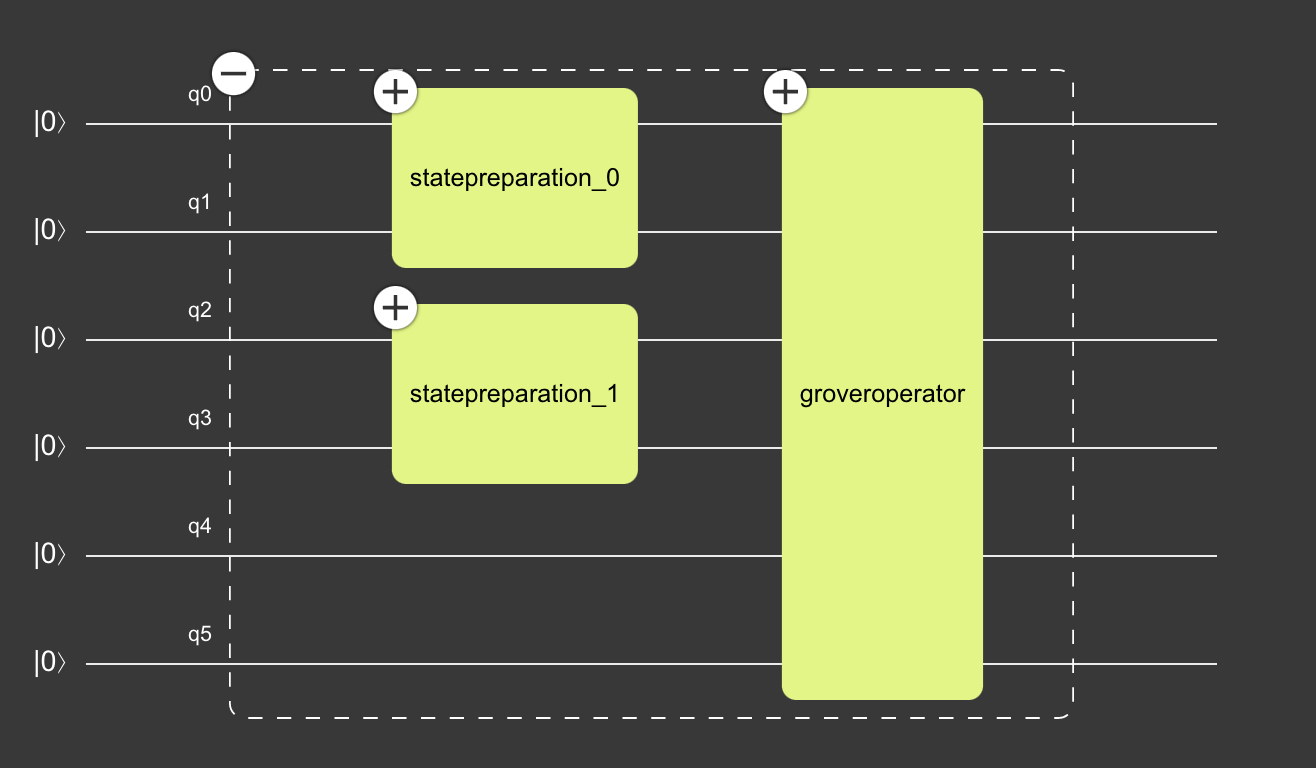

Let's see how our circuit is mapped to different hardwares:

In [ ]:
from classiq import Analyzer

analyzer = Analyzer(circuit=circuit)
analyzer.get_hardware_comparison_table(providers=["Azure Quantum", "IBM Quantum"])
analyzer.plot_hardware_comparison_table()

## Executing on a Simulator and analyzing the results

We want to see the results of running the circuit on a simulator:

In [ ]:
from classiq import execute

results_raw = execute(qprog).result()

In [ ]:
from classiq.execution import ExecutionDetails

results = results_raw[0].value
print(results.counts_of_multiple_outputs(["a", "b"]))

The order of the strings in the Classiq Platform is that the MSB is on the right and that the LSB is on the left, i.e. '10'=1 and '01' = 2.

From the above dictionary, one can see that the most common results are ${(2,2),(1,3),(3,1)}$ with total number of shots of $928$ out of $1000$. Thus indeed the algorithm has succeeded and outputs the correct results!

### Executing our first circuit on the platform's web application

We can also execute our circuit through the web application.
Once we have our circuit loaded to the web application, either by the `show` function (used above) or by uploading it from a file, the execution icon will appear on the sidebar on the left. We can click this icon to go to the execution page. This page contains two sections: Quantum Devices and Execution Management. Let's execute our circuit on the IBM Quantum `aer_simulator` with 1000 shots:

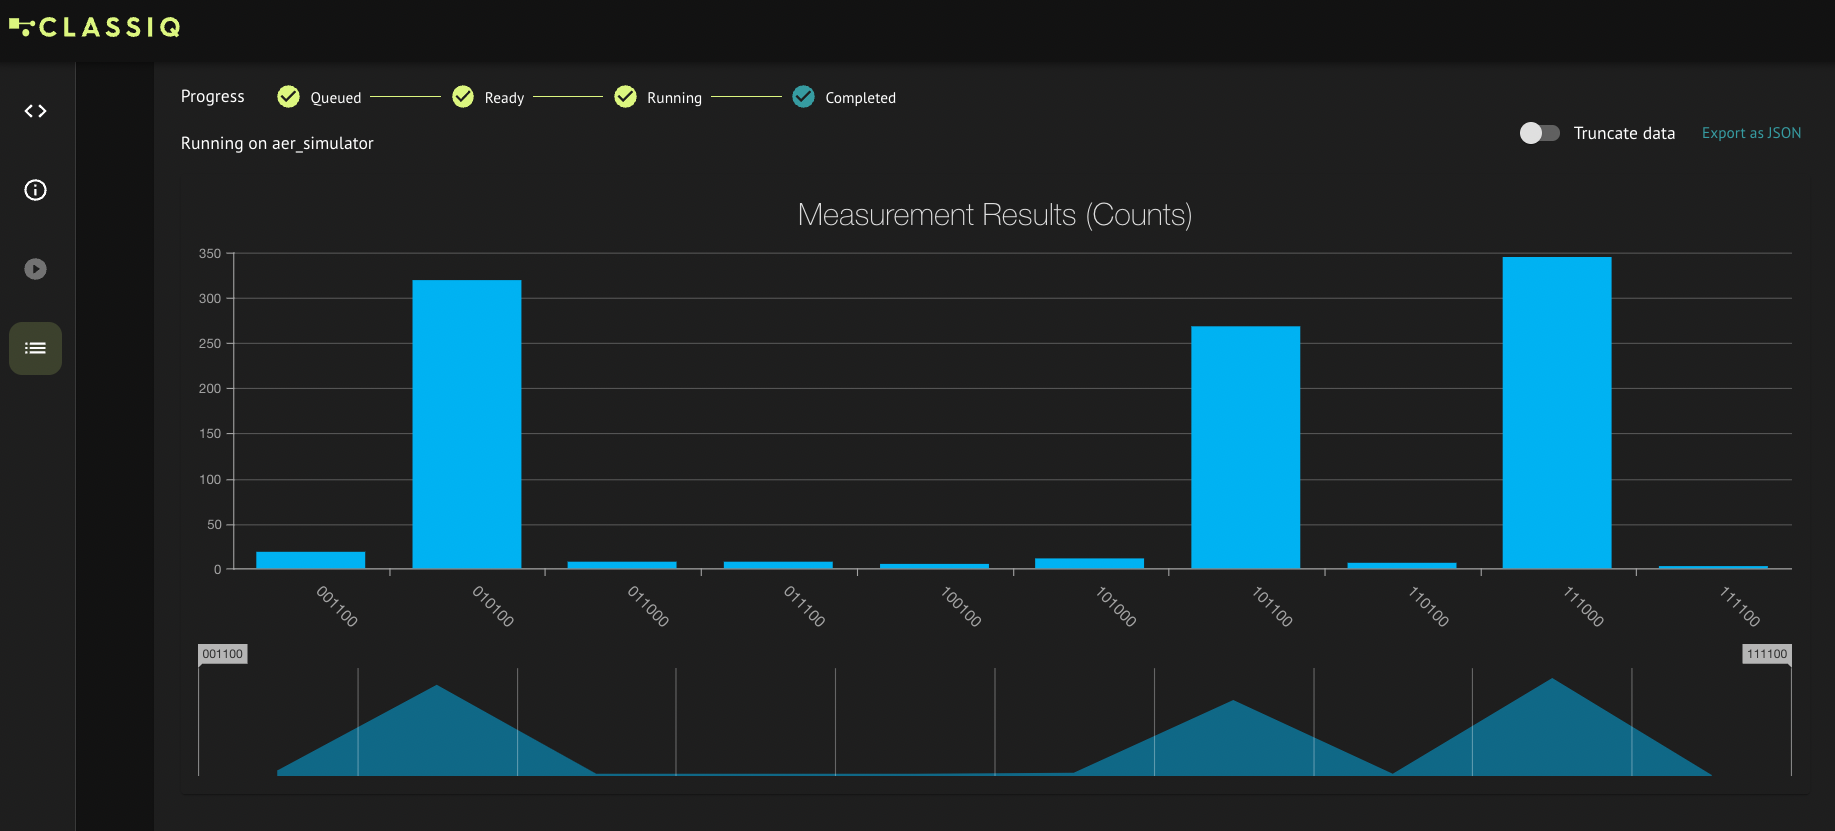

The order of the strings in the Classiq Platform is that the MSB is on the right and that the LSB is on the left, i.e. '10'=1 and '01' = 2.

From the above, one can see that the most common results are  (2,2),(1,3),(3,1)

We get the expected results!

## All Code Together

In [ ]:
import numpy as np

from classiq import (
    Analyzer,
    GeneratedCircuit,
    Model,
    RegisterUserInput,
    execute,
    set_constraints,
    show,
    synthesize,
)
from classiq.builtin_functions import ArithmeticOracle, GroverOperator, StatePreparation
from classiq.execution import (
    ExecutionDetails,
    ExecutionPreferences,
    IBMBackendPreferences,
)
from classiq.model import Constraints
from classiq.synthesis import set_execution_preferences

# Defining probabilities
prob_a = [0, 1 / 3, 1 / 3, 1 / 3]
prob_b = [0, 1 / 3, 1 / 3, 1 / 3]
prob_ab = np.kron(prob_b, prob_a)

# The StatePreperation objects
sp_a = StatePreparation(probabilities=prob_a, error_metric={"KL": {"upper_bound": 0.1}})
sp_b = StatePreparation(probabilities=prob_b, error_metric={"KL": {"upper_bound": 0.1}})
sp_ab = StatePreparation(
    probabilities=prob_ab, error_metric={"KL": {"upper_bound": 0.1}}
)

# How many qubits are per register of a and b?
num_of_qubits = 2

# Defining the oracle:
oracle = ArithmeticOracle(
    expression="a+b==4",
    definitions={
        "a": RegisterUserInput(size=num_of_qubits),
        "b": RegisterUserInput(size=num_of_qubits),
    },
    uncomputation_method="optimized",
)

# Defining the Grover operator
grover = GroverOperator(oracle_params=oracle, state_preparation_params=sp_ab)

# number of iterations
total_num_of_qubits = 2 * num_of_qubits
N = 3**2
M = 3
num_of_iterations = int(np.round(np.pi / 4 * np.sqrt(N / M)))
print("#iterations =", num_of_iterations)

# The model
model = Model()
model.sample()

# Wiring the Model - state preperations
a = model.StatePreparation(params=sp_a)
b = model.StatePreparation(params=sp_b)

# Transforming to a loop format
grover_dict = model.GroverOperator(
    params=grover, in_wires={"a": a["OUT"], "b": b["OUT"]}
)

# looping over all Grover operators (if more than 1)
for i in range(num_of_iterations - 1):
    grover_dict = model.GroverOperator(
        params=grover, in_wires={"a": grover_dict["a"], "b": grover_dict["b"]}
    )

# Setting the Outputs
model.set_outputs({"a": grover_dict["a"], "b": grover_dict["b"]})

# Defining the constraints
constraints = Constraints(max_width=12, optimization_parameter="width")
serialized_model = model.get_model()

serialized_model = set_constraints(serialized_model, constraints)

# Declare beckend
backend_preferences = IBMBackendPreferences(
    backend_service_provider="IBM Quantum", backend_name="aer_simulator_statevector"
)

serialized_model = set_execution_preferences(
    serialized_model,
    execution_preferences=ExecutionPreferences(
        num_shots=1000, backend_preferences=backend_preferences
    ),
)

# Synthesizing a circuit
qprog = synthesize(serialized_model)

# Visualizing the circuit
show(qprog)

# Analyzing with hardware comparison table
circuit = GeneratedCircuit.from_qprog(qprog)
analyzer = Analyzer(circuit=circuit)
analyzer.get_hardware_comparison_table(providers=["Azure Quantum", "IBM Quantum"])
analyzer.plot_hardware_comparison_table()

# Simulating the results
results_raw = execute(qprog).result()
results = results_raw[0].value
print(results.counts_of_multiple_outputs(["a", "b"]))